In [1]:
#Importing Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

In [2]:
#Reading the Input CSV file
df_energy = pd.read_csv(
    "household_power_consumption.txt",
    sep=';',
    na_values='?',
    parse_dates={'datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False
)


C:\Users\sreekarpersonal\AppData\Local\Temp\ipykernel_1572\1129945630.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_energy = pd.read_csv(
C:\Users\sreekarpersonal\AppData\Local\Temp\ipykernel_1572\1129945630.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy = pd.read_csv(
C:\Users\sreekarpersonal\AppData\Local\Temp\ipykernel_1572\1129945630.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_energy = pd.read_csv(


In [3]:
df_energy.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df_energy.set_index('datetime', inplace=True)
df_energy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df_energy = df_energy.astype('float32')

HANDLING OF MISSING DATA.

In [6]:
# Handling Missing data
df_energy.ffill(inplace=True)

In [7]:
series = df_energy['Global_active_power']

Minute-level data was aggregated to daily averages to reduce noise and make ARIMA modeling computationally stable.

In [8]:
series = series.resample('D').mean()

In [9]:
print(series.isna().sum()) # ensuring missing values are zero
print(series.head())
print(series.tail())


0
datetime
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
Freq: D, Name: Global_active_power, dtype: float32
datetime
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, dtype: float32


VISUALIZATION OF THE TIME SERIES (GLOBAL ACTIVE POWER)

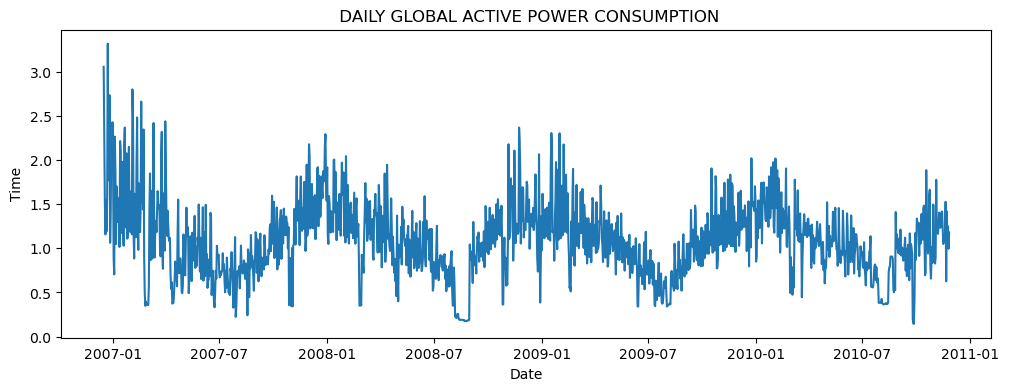

In [10]:
plt.figure(figsize=(12,4))
plt.plot(series)
plt.title(' DAILY GLOBAL ACTIVE POWER CONSUMPTION')
plt.xlabel('Date')
plt.ylabel('Time')
plt.show()

COMPUTING ROLLING MEAN AND ROLLING STANDARD DEVIATION

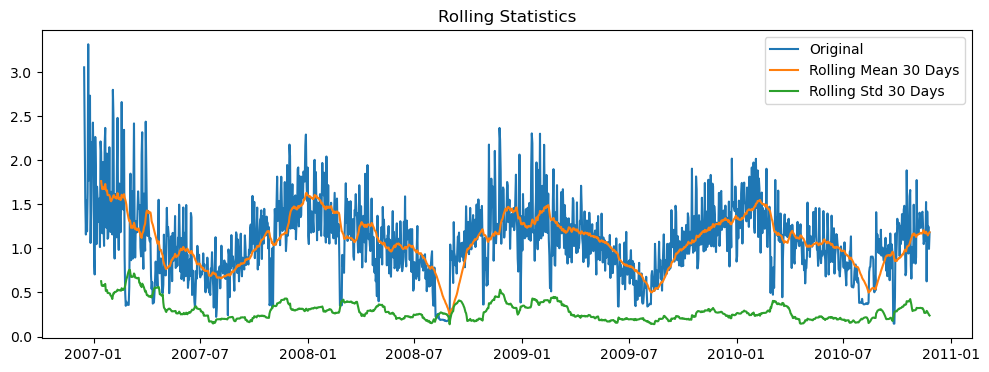

In [11]:
#Computing rolling mean and std to visually assess stationarity by observing whether the mean and variance remain constant over time.
rolling_mean = series.rolling(window = 30).mean()
rolling_std= series.rolling(window=30).std()

plt.figure(figsize = (12,4))
plt.plot(series,label = 'Original')
plt.plot(rolling_mean,label='Rolling Mean 30 Days')
plt.plot(rolling_std,label ='Rolling Std 30 Days')
plt.legend()
plt.title('Rolling Statistics')
plt.show()

AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
#Null Hypothesis : Data(Series) has unit root so it is not stationary
#Alternate Hypothesis : Data(Series) has no root so it is stationary

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistics: {result[0]}")
    print(f'p-value : {result[1]}')
    if result[1] <=0.05:
        print('Against Null Hypothesis,Reject the Null Hypothesis.Data has No unit root so it is stationary.')
    else:
        print('With Null Hypothesis,Accept the Null Hypothesis.Data has unit root so it is  non-stationary.')

STATIONARITY TEST FOR DAILY SERIES, NOT THE RAW MINUTE LEVEL DATA.

In [14]:
#Checking for Stationarity using above adf function.
adf_test(series)

ADF Statistics: -3.734758714406703
p-value : 0.003649972684208245
Against Null Hypothesis,Reject the Null Hypothesis.Data has No unit root so it is stationary.


P AND Q PARAMETERS IDENTIFICATION USING ACF AND PACF

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

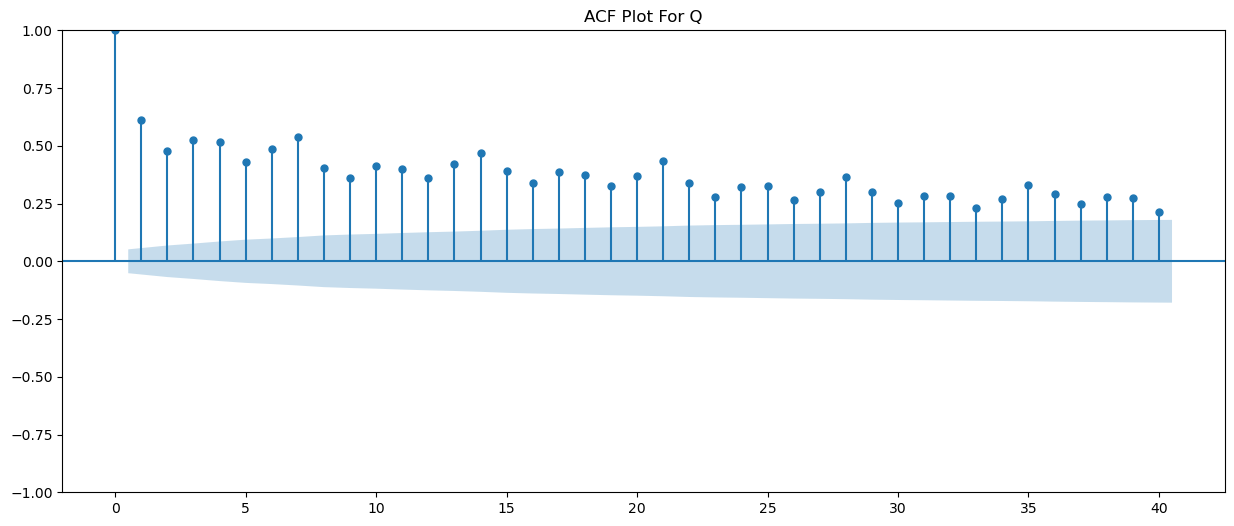

In [16]:
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(series,lags=40,ax=ax)
plt.title('ACF Plot For Q')
plt.show()

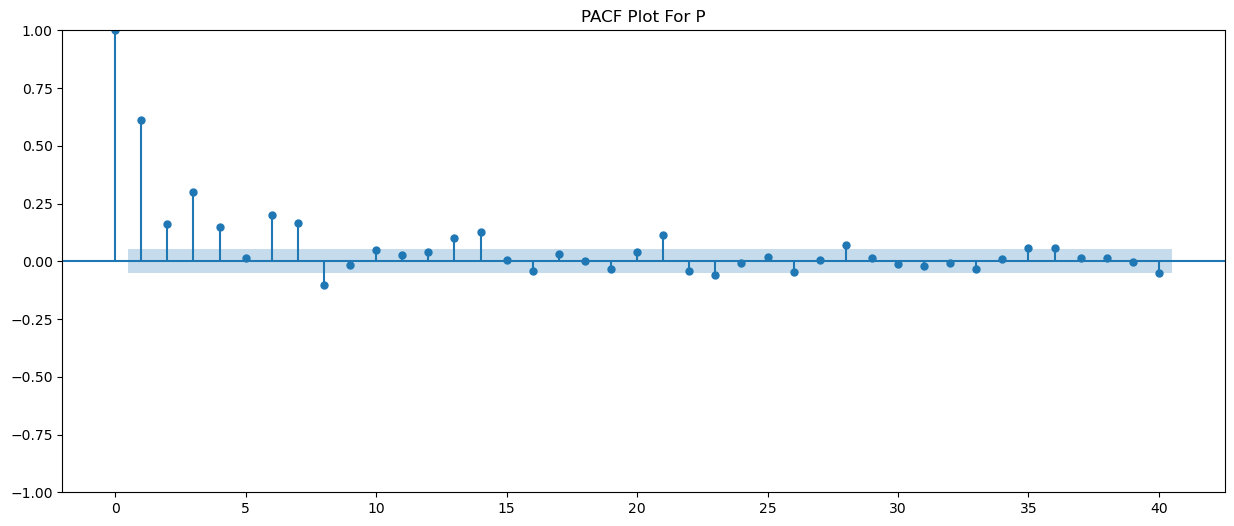

In [17]:
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(series,lags=40,ax=ax,method='ywm') #YWM -> Yule-Walker Method
plt.title('PACF Plot For P')
plt.show()

TRAIN-TEST SPLIT

In [18]:
size_train= int(len(series)*0.8)
train = series[:size_train]
test = series[size_train:]

FIT ARIMA(2,0,1) ON TRAIN DATA

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train,order=(2,0,1))
fit = model.fit()

print(fit.summary())

C:\Users\sreekarpersonal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sreekarpersonal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1153
Model:                  ARIMA(2, 0, 1)   Log Likelihood                -325.786
Date:                 Fri, 19 Dec 2025   AIC                            661.573
Time:                         16:47:22   BIC                            686.823
Sample:                     12-16-2006   HQIC                           671.103
                          - 02-10-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1913      0.137      8.706      0.000       0.923       1.460
ar.L1          1.2118      0.031     39.026      0.000       1.151       1.273
ar.L2         -0.2207      0.029     -7.523 

PREDICTING THE TEST DATA 

In [20]:
predict = fit.forecast(steps=len(test))

PLOTTING THE ACTUAL VS PREDICTED

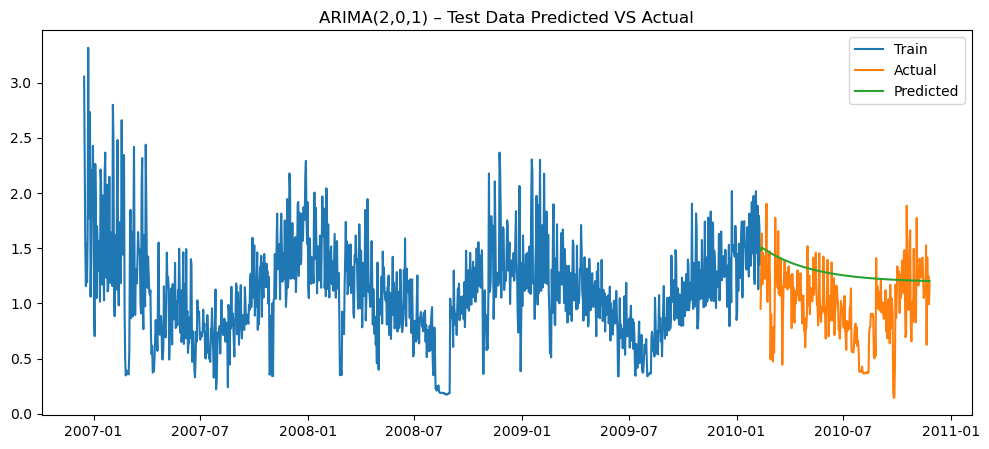

In [21]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train,label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predict, label='Predicted')
plt.legend()
plt.title("ARIMA(2,0,1) – Test Data Predicted VS Actual")
plt.show()

EVALUATION METRICS

Evaluation metrics quantify how close the model’s predictions are to the actual test values.

RMSE - ROOT MEAN SQUARED ERROR

RMSE tells how far, on average, the predicted values are from the actual values, measured in the same units as the data.

MAPE - MEAN ABSOLUTE PERCENTAGE ERROR

MAPE tells the average percentage error between the predicted and actual values, indicating relative prediction accuracy.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test, predict))
mape = mean_absolute_percentage_error(test, predict)
print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 0.42416791987878916
MAPE: 0.5481517701470963


The ARIMA(2,0,1) model achieved an RMSE of 0.42, indicating moderate prediction error in absolute terms. The MAPE value is relatively high due to sensitivity to low power values, which is a known limitation of percentage-based error metrics.

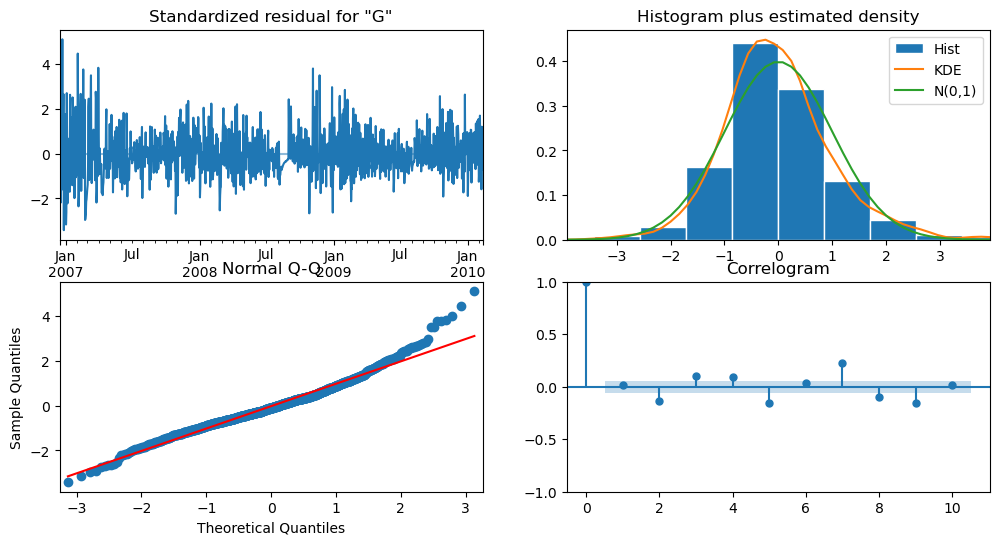

In [23]:
fit.plot_diagnostics(figsize=(12,6))
plt.show()


Standardized Residuals:

Residuals fluctuate around zero with no clear trend.
This indicates the main temporal structure is captured.

Histogram with KDE:

Residuals are approximately bell-shaped around zero.
Slight skewness and heavy tails are observed.

Normal Q–Q Plot:

Points align well with the diagonal in the center.
Deviations appear at the extreme tails.

Residual ACF (Correlogram):

Most autocorrelations lie within or near confidence bounds.
No systematic residual autocorrelation is present.

Overall Diagnostic Conclusion:

Residuals behave approximately like white noise.
The ARIMA(2,0,1) model is adequate for forecasting.

FITTING ARIMA ON FULL DATA

In [24]:
final_model = ARIMA(series, order=(2,0,1))#Refit on full data (final model)
final_fit = final_model.fit()


C:\Users\sreekarpersonal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sreekarpersonal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


PREDICTING THE FUTURE VALUES

In [25]:
future_steps = 30
future_forecast = final_fit.forecast(steps=future_steps)

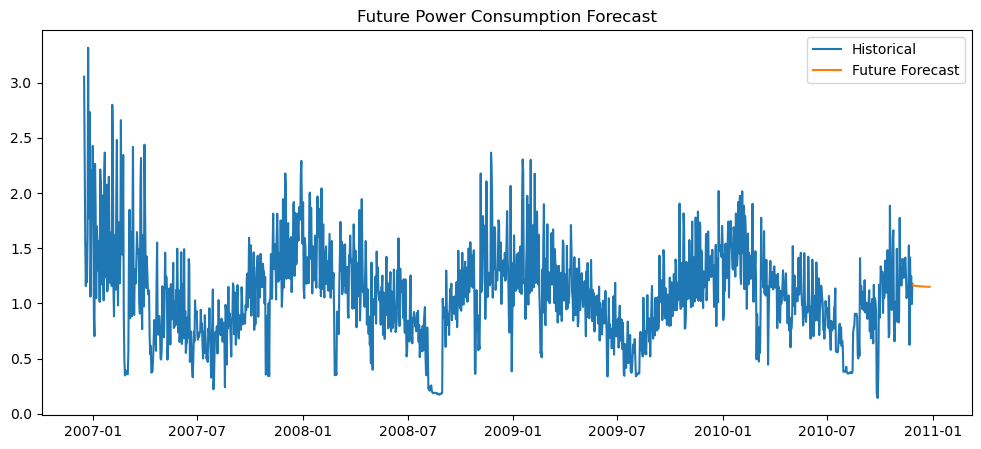

In [26]:
plt.figure(figsize=(12,5))
plt.plot(series,label='Historical')
plt.plot(future_forecast, label='Future Forecast')
plt.legend()
plt.title("Future Power Consumption Forecast")
plt.show()

FUTURE FORECASTING WITH PROPER INDEX AND INCREASE IN FUTURE STEPS.

In [27]:
future_steps1= 180

future_index = pd.date_range(
    start=series.index[-1],
    periods=future_steps1+1,
    freq='D'
)[1:]

future_forecast1 = final_fit.forecast(steps=future_steps1)

future_forecast_indexed = pd.Series(future_forecast1, index=future_index)


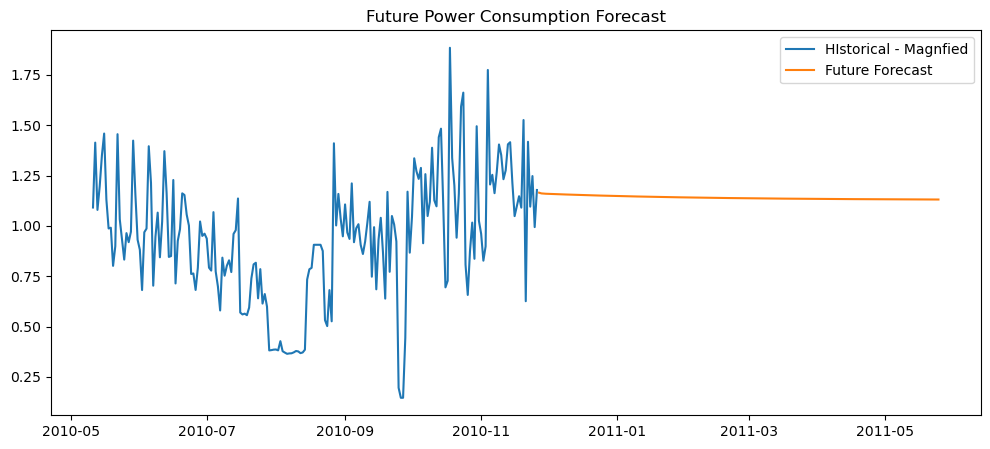

In [28]:
plt.figure(figsize=(12,5))
plt.plot(series[-200:],label = 'HIstorical - Magnfied')
plt.plot(future_forecast_indexed,label='Future Forecast')
plt.legend()
plt.title('Future Power Consumption Forecast')
plt.show()

The 180-day forecast extends beyond the historical period and converges smoothly toward the long-term mean, which is characteristic of non-seasonal ARIMA models.

An ARIMA(2,0,1) model was developed to forecast daily household power consumption.

The model demonstrated reasonable predictive accuracy on unseen data and passed residual diagnostic checks.

Future forecasts show convergence toward the long-term mean, consistent with non-seasonal ARIMA behavior.

The model does not capture short-term volatility or seasonality, which could be addressed using SARIMA or machine learning models.